# 0. Load functions and set parameters

In [1]:
# %matplotlib notebook

import os, h5py, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import signal
from scipy.optimize import curve_fit
from scipy.stats import zscore

sys.path.append('../')
from visualize_functions import show_images, plot_curve, show_grid_plots, label_violinplot
from analyze_spot_functions import NormalizeData
from fitting_functions import load_curve, load_multiple_curves, detect_peaks, remove_outlier, fit_exp, analyze_curves

# from analyze_RHEED_spot_functions import show_metrics, Gaussian, generate_parameter_file, show_sound, show_fft_frequency, butter_filter, process_pass_filter
# from analyze_RHEED_intensity_functions import NormalizeData, trim_axes, show_images, show_plots
plt.rcParams.update(mpl.rcParamsDefault)

green_cb = (27/255,158/255,119/255)
orange_cb = (217/255,95/255,2/255)
purple_cb = (117/255,112/255,179/255)

rc_plot = {'figure.figsize':(12,2.5),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 18,

          'xtick.labelsize': 14,
          'xtick.direction': 'in',
          'xtick.top': True,
          'xtick.bottom': True,
          'xtick.labelbottom': True,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 14,
          'ytick.direction': 'in',
          'ytick.right': True,
          'ytick.left': True,
          'ytick.labelleft': True,
          'ytick.labelright': False,

          'legend.fontsize': 10,
          'font.family': 'sans-serif'}

rc_img = {'figure.figsize':(8,8),
          'axes.facecolor':'white',
          'axes.grid': False,
          'axes.titlesize': 18,
          'axes.labelsize': 14,
          
          'xtick.labelsize': 12,
          'xtick.direction': 'in',
          'xtick.top': False,
          'xtick.bottom': False,
          'xtick.labelbottom': False,
          'xtick.labeltop': False,
          
          'ytick.labelsize': 12,
          'ytick.direction': 'in',
          'ytick.right': False,
          'ytick.left': False,
          'ytick.labelleft': False,
          'ytick.labelright': False,

          'legend.fontsize': 8,
          'font.family': 'sans-serif'}

# 1. Visualize the spots from collected data

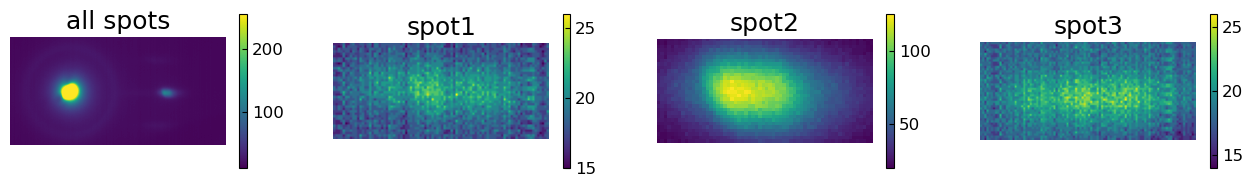

In [2]:
plt.rcParams.update(rc_img)

imgs = []
region = [(45, 85, 360, 450), (140, 170, 408, 470), (220, 265, 355, 455)]
with h5py.File('/scratch/yichen/RHEED_data/STO_STO_test7_06292022.h5', mode='r') as h5:
    spots_name = ['spot1', 'spot2', 'spot3']
    img_all_spots = np.array(h5['growth_2'][20])
    plt.imsave('../figures/1.test7_all_spots.png', img_all_spots)
    
    imgs.append(img_all_spots)
    for i, sn in enumerate(spots_name):
        imgs.append(NormalizeData(img_all_spots[region[i][0]:region[i][1], region[i][2]:region[i][3]]).astype(np.float32))
        plt.imsave('../figures/1.test7_'+sn+'.png', imgs[i])

show_images(imgs, ['all spots']+spots_name, img_per_row=4, img_height=0.1, colorbar=True)

# 2. Visualize RHEED intensity oscillation

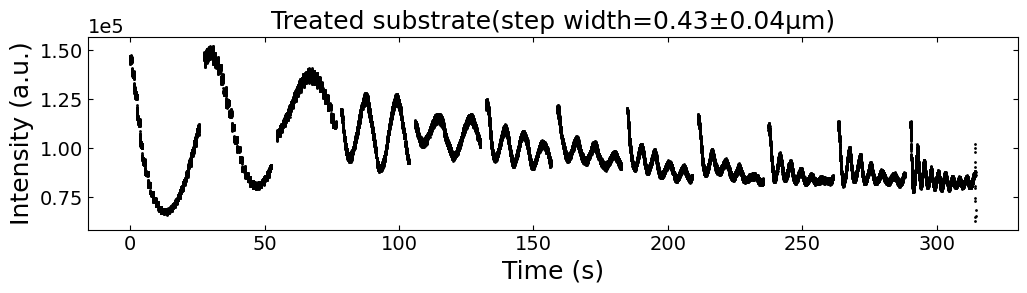

In [3]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 'growth_6':5, 
               'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', 
                                    title=title, x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=title, figsize=(12,2.5))

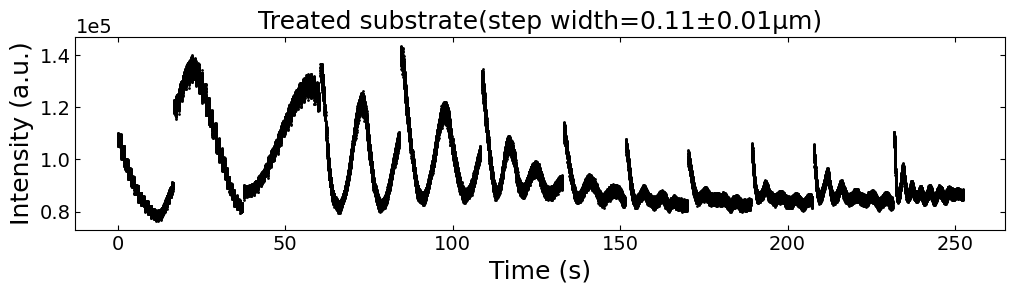

In [4]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
title = 'Treated substrate(step width=0.11±0.01μm)'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 
               'growth_6':5, 'growth_7':5, 'growth_8':7, 'growth_9':7, 'growth_10':9, 
               'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', 
                                    title=title, x_start=0, interval=200)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=title, figsize=(12,2.5))

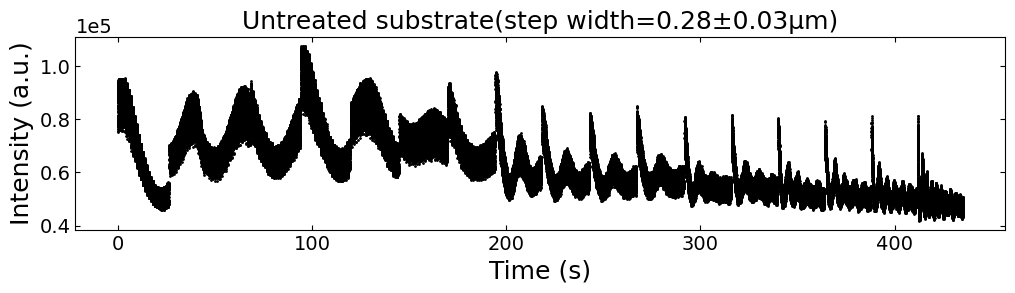

In [5]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
title = 'Untreated substrate(step width=0.28±0.03μm)'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1, 
               'growth_06':1, 'growth_07':1, 'growth_08':1, 'growth_09':3, 'growth_10':3, 
               'growth_11':3, 'growth_12':3, 'growth_13':5, 'growth_14':5, 'growth_15':7, 
               'growth_16':7, 'growth_17':9, 'growth_18':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', 
                                    title=title, x_start=0, interval=200)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', title=title, figsize=(12,2.5))

# 3. Growth mechanism analysis - first unit cell of sample 1

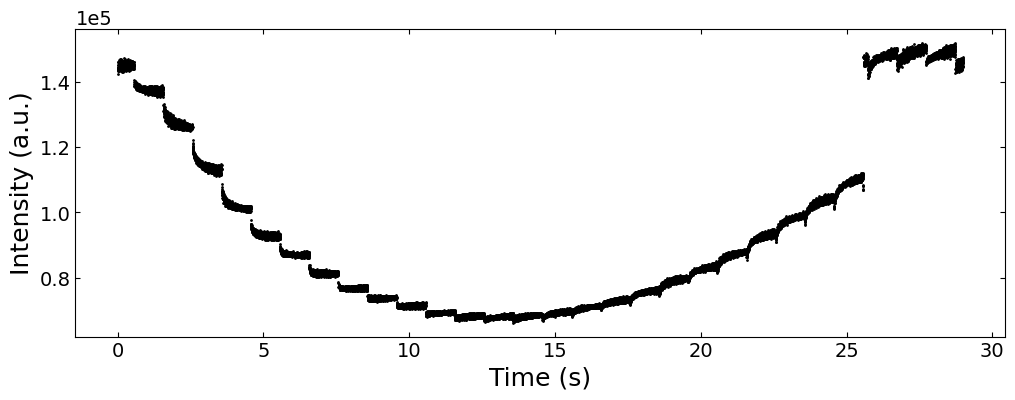

In [6]:
plt.rcParams.update(rc_plot)

h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
# title = 'Treated substrate(step width=0.43±0.04μm)'
growth_dict = {'growth_1.':1, 'growth_2':1}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', 
                                    title=title, x_start=0, interval=0)
x_sample = x_all[x_all<29]
y_sample = y_all[x_all<29]
plot_curve(x_sample, y_sample, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,4))

# 4. Diffusion time constant
## 4.1 Fitting process:
### Treated substrate(step width=0.43±0.04μm) - growth_1

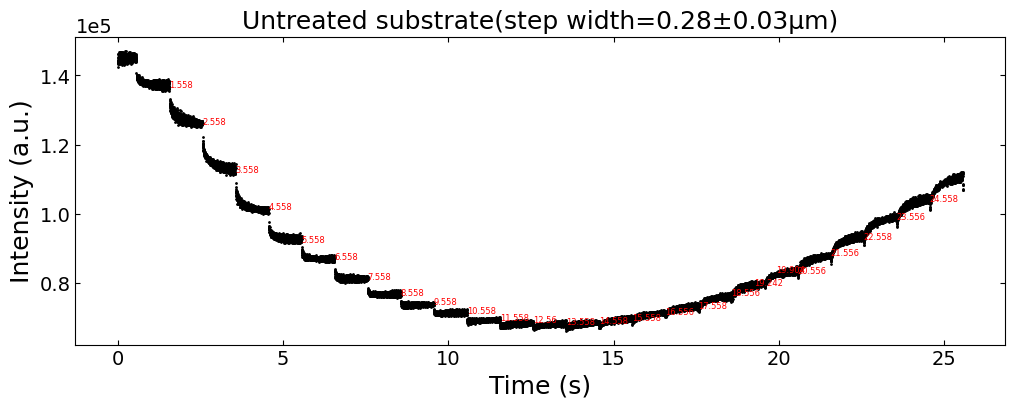

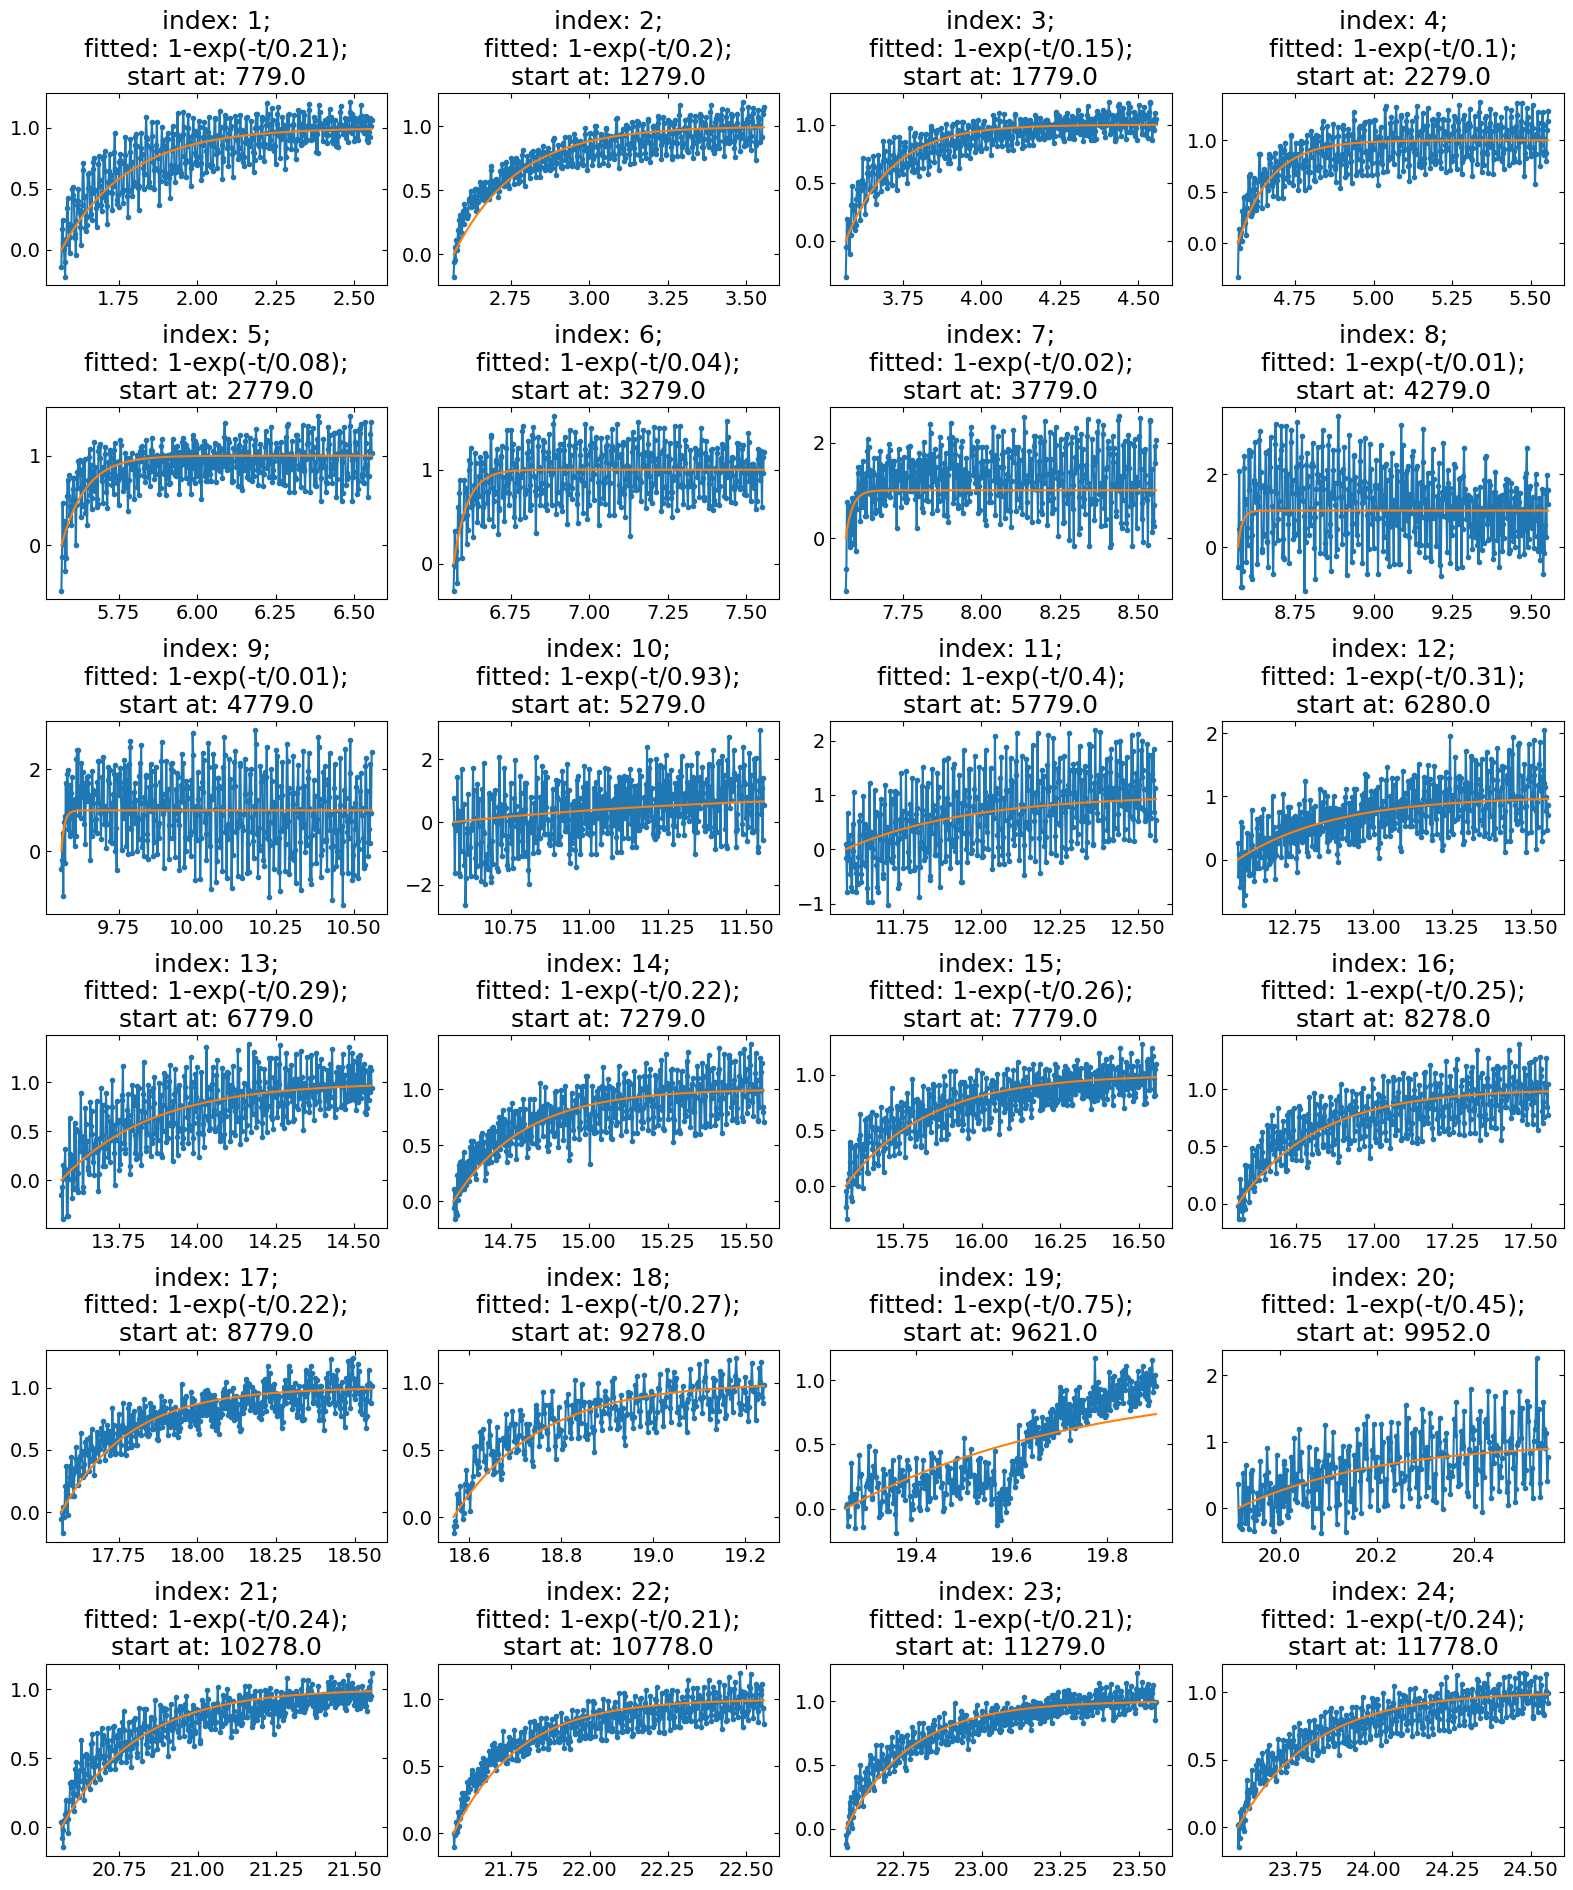

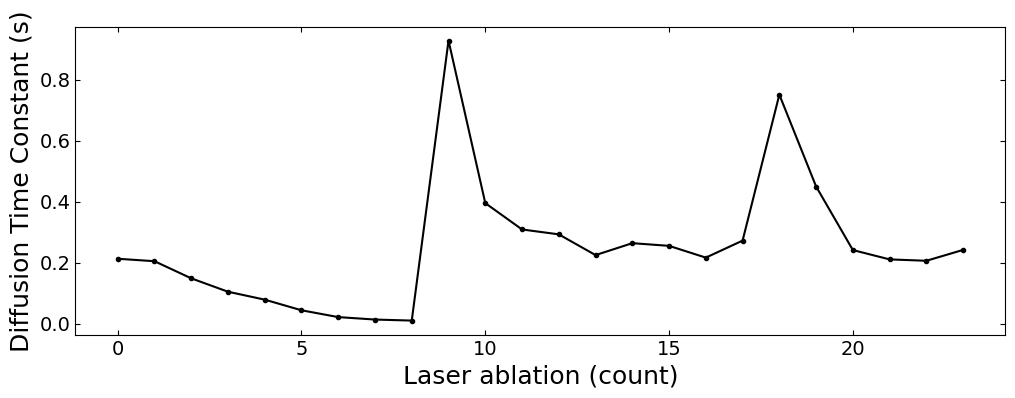

In [7]:
plt.rcParams.update(rc_plot)

# title = 'Treated substrate(step width=0.43±0.04μm) - growth_1'
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'

# load data
sample_x, sample_y = load_curve(h5_para_file, 'growth_1.', 'spot_2', 'img_intensity', camera_freq=500, x_start=0, figsize=(12,4))

# detect peaks
x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=500, laser_freq=1, step_size=5, prominence=0.1)
plot_curve(sample_x, sample_y, x_peaks=x_peaks, plot_type='scatter', xlabel='Time (s)', ylabel='Intensity (a.u.)',
           title=title, figsize=(12, 4))

# fit exponential function
tau_list, labels, ys_fit, info = fit_exp(xs, ys, tau_=0.1, x_peaks=x_peaks, ylim=None, camera_freq=500)
sign_list, I_start_list, I_end_list = info
show_grid_plots(xs, ys, labels, ys_fit, ylim=None)
x_tau = np.linspace(0, len(tau_list)-1, len(tau_list))
plot_curve(x_tau, tau_list, plot_type='lineplot', xlabel='Laser ablation (count)', ylabel='Diffusion Time Constant (s)', 
           yaxis_style='linear', figsize=(12, 4))

## 4.2 Collect diffusion time constant for three samples

### 4.2.1 Treated substrate (step width=0.43±0.04μm)

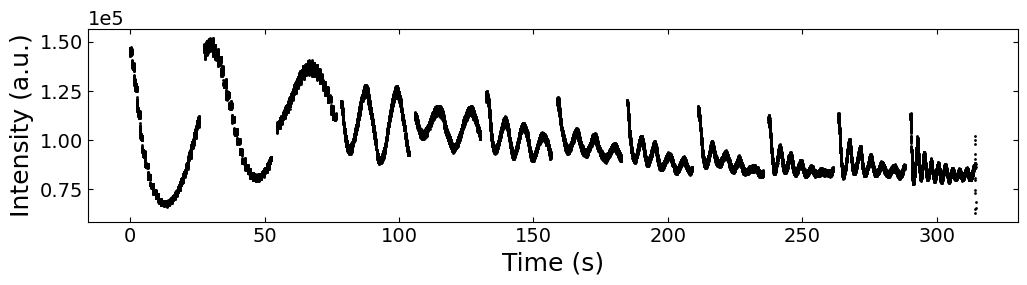

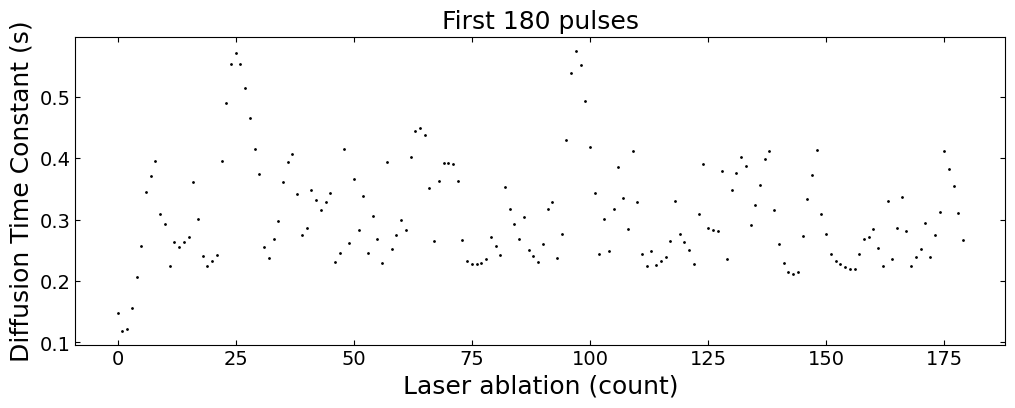

In [14]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test6_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 'growth_5':3, 'growth_6':5, 'growth_7':5, 
               'growth_8':7, 'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}

x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', 
                                    title=title, x_start=0, interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5),
           save_path)
   
n_ablation = 180
tau_sample1 = analyze_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', camera_freq=500)
x_tau_sample1 = np.linspace(0, len(tau_sample1)-1, len(tau_sample1))
plot_curve(x_tau_sample1[:n_ablation], tau_sample1[:n_ablation], plot_type='scatter', xlabel='Laser ablation (count)', ylabel='Diffusion Time Constant (s)', 
           yaxis_style='linear', title='First 180 pulses', figsize=(12, 4))

### 4.2.2 Treated substrate (step width=0.11±0.01μm)

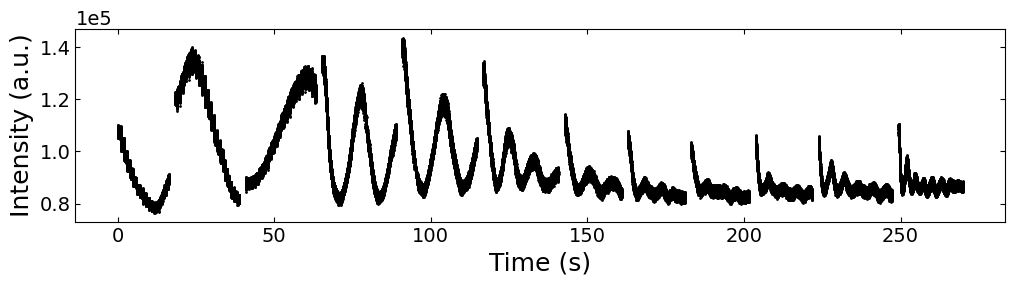

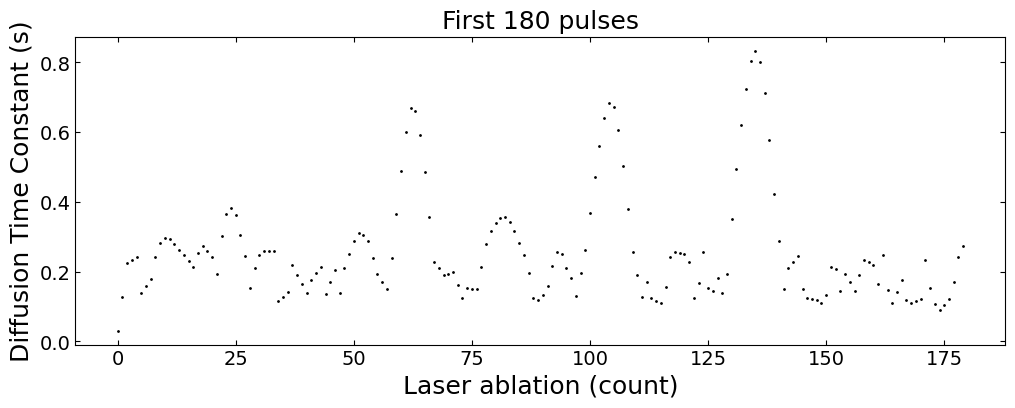

In [15]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test7_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_1.':1, 'growth_2':1, 'growth_3':1, 'growth_4':3, 
               'growth_5':3, 'growth_6':5, 'growth_7':5, 'growth_8':7, 
               'growth_9':7, 'growth_10':9, 'growth_11':9, 'growth_12':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5))

n_ablation = 180
tau_sample2 = analyze_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', camera_freq=500)
x_tau_sample2 = np.linspace(0, len(tau_sample2)-1, len(tau_sample2))
plot_curve(x_tau_sample2[:n_ablation], tau_sample2[:n_ablation], plot_type='scatter', xlabel='Laser ablation (count)', ylabel='Diffusion Time Constant (s)', 
           yaxis_style='linear', title='First 180 pulses', figsize=(12, 4))

### 4.2.3 Untreated substrate (step width=0.28±0.03μm)

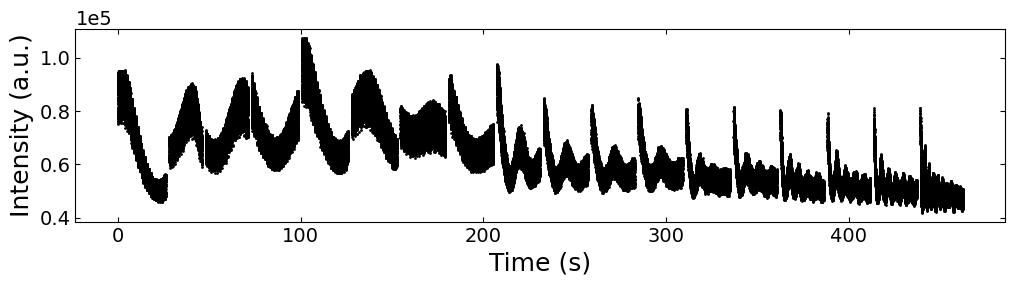

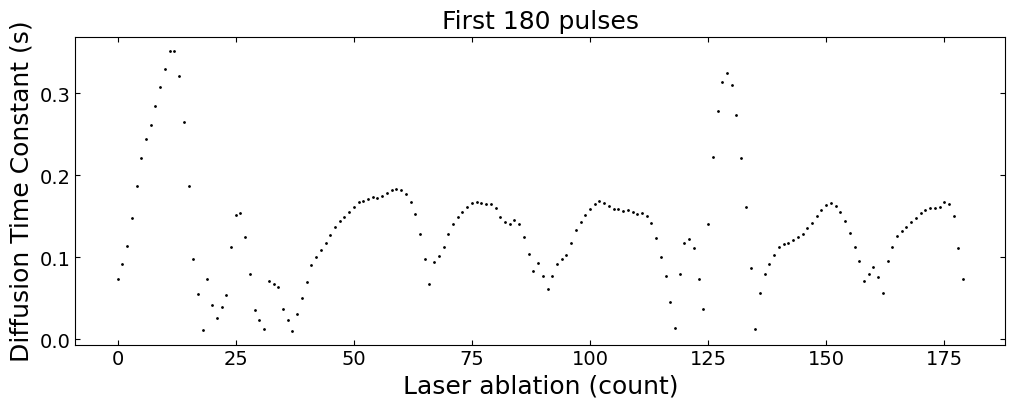

In [16]:
plt.rcParams.update(rc_plot)
h5_para_file = '../../data/test9_gaussian_fit_parameters_all.h5'
growth_dict = {'growth_01':1, 'growth_02':1, 'growth_03':1, 'growth_04':1, 'growth_05':1, 
               'growth_06':1, 'growth_07':1, 'growth_08':1, 'growth_09':3, 'growth_10':3, 
               'growth_11':3, 'growth_12':3, 'growth_13':5, 'growth_14':5, 'growth_15':7, 
               'growth_16':7, 'growth_17':9, 'growth_18':15}
x_all, y_all = load_multiple_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', interval=1000)
plot_curve(x_all, y_all, xlabel='Time (s)', ylabel='Intensity (a.u.)', figsize=(12,2.5))

# plot tau before laser ablation=180
n_ablation = 180
tau_sample3 = analyze_curves(h5_para_file, growth_dict, 'spot_2', 'img_intensity', camera_freq=500)
x_tau_sample3 = np.linspace(0, len(tau_sample3)-1, len(tau_sample3))
plot_curve(x_tau_sample3[:n_ablation], tau_sample3[:n_ablation], plot_type='scatter', xlabel='Laser ablation (count)', ylabel='Diffusion Time Constant (s)', 
           yaxis_style='linear', title='First 180 pulses', figsize=(12, 4))

## 4.3 Summary of diffusion time constant

### 4.3.1 Violinplot 

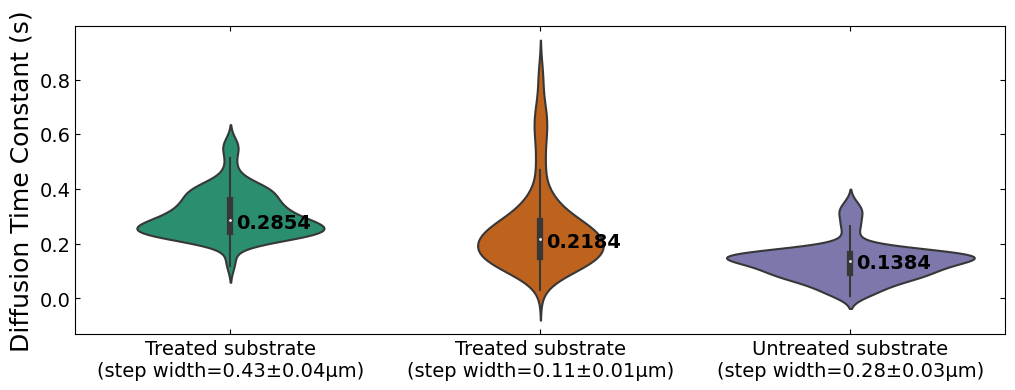

In [11]:
data = [tau_sample1[:n_ablation], tau_sample2[:n_ablation], tau_sample3[:n_ablation]]
fig, ax = plt.subplots(figsize=(12,4))

ax = sns.violinplot(data=data, palette=[green_cb, orange_cb, purple_cb])
ax.set_xticklabels([title_sample1, title_sample2, title_sample3])

label_violinplot(ax, data, label_type='average', text_pos='left')
ax.set_ylabel('Diffusion Time Constant (s)')
plt.savefig('images/4.violinplot.svg', bbox_inches='tight', dpi=300)
plt.show()

### 4.3.2 Linear trend

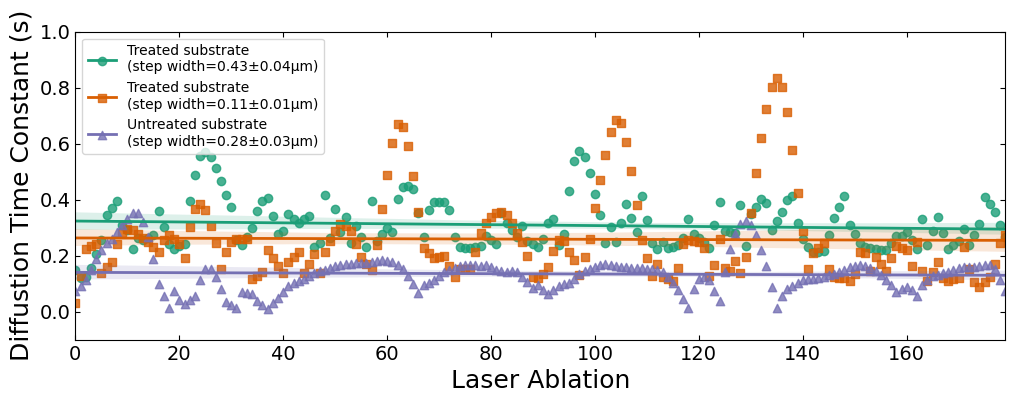

In [18]:
plt.rcParams.update(rc_plot)

fig, ax = plt.subplots(1, 1, figsize=(12,4))
sns.regplot(ax=ax, x=x_tau_sample1[:n_ablation], y=tau_sample1[:n_ablation], label=title_sample1, 
            line_kws={'lw': 2, 'label': title_sample1},
            scatter=True, marker='o', color=green_cb)
sns.regplot(ax=ax, x=x_tau_sample2[:n_ablation], y=tau_sample2[:n_ablation], label=title_sample2,
            line_kws={'lw': 2, 'label': title_sample2},
            scatter=True, marker='s', color=orange_cb)
sns.regplot(ax=ax, x=x_tau_sample3[:n_ablation], y=tau_sample3[:n_ablation], label=title_sample3,
            line_kws={'lw': 2, 'label': title_sample3},
            scatter=True, marker='^', color=purple_cb)
handles, labels = ax.get_legend_handles_labels()

n = 3
plt.legend(handles=[(h1, h2) for h1, h2 in zip(handles[:n], handles[n:])], labels=labels[n:], 
           fontsize=10)

plt.xlabel('Laser Ablation')
plt.ylabel('Diffustion Time Constant (s)')
plt.ylim(-0.1, 1.0)
plt.savefig('images/4.linear_trend.svg', bbox_inches='tight', dpi=300)
plt.show()